## MODELOS DE Feed Forward NN PARA DEMANDA DE GAS NATURAL EN SECTOR ELÉCTRICO EN MÉXICO


Importamos la data de Demanda de gas en sector eléctrico como un CSV

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [33]:
csv_demanda_electrico_original = pd.read_csv('Demanda_electrico_2022_full1.csv',index_col='Date',parse_dates=True)
csv_demanda_electrico_original

,Demanded_Gas
Date,
2005-01-01,1819.58
2005-02-01,1895.33
2005-03-01,1765.86
2005-04-01,1642.70
2005-05-01,1895.54
...,...
2022-05-01,3350.03
2022-06-01,3498.70
2022-07-01,3350.97


Vamos a graficar los datos "originales" de demanda eléctrico desde 2005 hasta 2022

Text(0, 0.5, 'Demanda [MMpcd]')

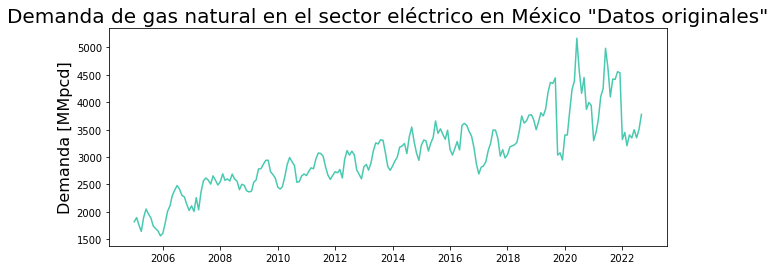

In [34]:
plt.figure(figsize=(10,4))
plt.plot(csv_demanda_electrico_original, color='#48C9B0')
plt.title('Demanda de gas natural en el sector eléctrico en México "Datos originales"', fontsize=20)
plt.ylabel('Demanda [MMpcd]', fontsize =16)

Vamos a descomponer la serie de tiempo de datos "originales" de demanda eléctrico desde 2005 hasta 2022 en sus compoentes de Tendencia, Estacionalidad y Residual 

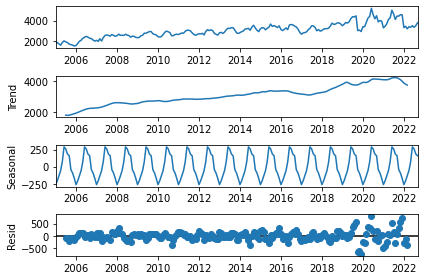

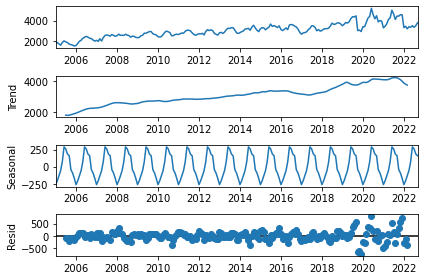

In [35]:
from statsmodels.tsa.seasonal import seasonal_decompose

csv_demanda_electrico_original_seasonal_decomposition = seasonal_decompose(csv_demanda_electrico_original)
csv_demanda_electrico_original_seasonal_decomposition.plot()

Proceso de Pretratamiento (Ajuste de vaores atípicos por media aritmetica de serie) como una estrategia para mejorar los resultados de forecast de modelos Feed Forward Neural Networks

In [37]:
outlier_threshold = 1.2

import pandas as pd

def remove_replace_outliers(data):
    # Calculate Q1 and Q3
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1

    # Identify outliers
    outliers_mask = (data < (Q1 - outlier_threshold * IQR)) | (data > (Q3 + outlier_threshold * IQR))

    # Calculate the historical meadian excluding outliers
    historical_median = np.median(data[~outliers_mask])

    # Replace outliers with historical mean
    data.loc[outliers_mask] = historical_median

    return data

In [38]:
csv_demanda_electrico_pretratamiento_median = remove_replace_outliers(csv_demanda_electrico_original['Demanded_Gas'])
csv_demanda_electrico_pretratamiento_median

Date
2005-01-01    1819.580
2005-02-01    1895.330
2005-03-01    2960.295
2005-04-01    2960.295
2005-05-01    1895.540
                ...   
2022-05-01    3350.030
2022-06-01    3498.700
2022-07-01    3350.970
2022-08-01    3506.420
2022-09-01    3778.370
Name: Demanded_Gas, Length: 213, dtype: float64

Separamos la Demanda de gas natural en el sector eléctrico en data de train y test

In [39]:
# Number of data points to keep for testing (in this case, the last 12)
num_test_points = 12

# Split the data into training and testing sets
csv_demanda_electrico_pretratamiento_median_train_data = csv_demanda_electrico_pretratamiento_median[:-num_test_points]
csv_demanda_electrico_pretratamiento_median_test_data = csv_demanda_electrico_pretratamiento_median[-num_test_points:]

csv_demanda_electrico_pretratamiento_median_train_data

Date
2005-01-01    1819.580
2005-02-01    1895.330
2005-03-01    2960.295
2005-04-01    2960.295
2005-05-01    1895.540
                ...   
2021-05-01    2960.295
2021-06-01    2960.295
2021-07-01    2960.295
2021-08-01    4098.810
2021-09-01    2960.295
Name: Demanded_Gas, Length: 201, dtype: float64

Se generan sets de n_input datos para con ellos predecir el t+1 dato, y así los siguientes n_input para predecir el t+1, etc 

In [40]:
from keras.preprocessing.sequence import TimeseriesGenerator

Se aplica el TimeseriesGnerator para producir sets de n_inputs + 1 output para el caso de

In [41]:
n_input = 36

data = csv_demanda_electrico_pretratamiento_median_train_data
targets = data 

demanda_electrico_pretratamiento_median_train_generator = TimeseriesGenerator(data, targets, length=n_input, batch_size=1)


In [42]:
demanda_electrico_pretratamiento_median_train_generator[0]

(array([[1819.58 , 1895.33 , 2960.295, 2960.295, 1895.54 , 2051.72 ,
         1962.05 , 1889.66 , 2960.295, 2960.295, 2960.295, 2960.295,
         2960.295, 1806.33 , 2006.88 , 2108.31 , 2298.9  , 2398.88 ,
         2480.62 , 2413.08 , 2298.49 , 2273.91 , 2134.41 , 2025.98 ,
         2108.85 , 2006.81 , 2259.02 , 2036.62 , 2361.78 , 2567.22 ,
         2618.43 , 2579.35 , 2506.83 , 2657.24 , 2577.97 , 2489.39 ]]),
 array([2548.33]))

Y entonces el numero de muestras formadas con el TimeseriesGenerator = Numero de elementos de array original - n_input

In [44]:
print("Total number of samples in the original training data = ", len(csv_demanda_electrico_pretratamiento_median_train_data)) 
print("Total number of samples in the demanda_electrico_scaled_train_generator = ", len(demanda_electrico_pretratamiento_median_train_generator))

Total number of samples in the original training data =  201
Total number of samples in the demanda_electrico_scaled_train_generator =  165


Se importan las librerias necesarias para definir la red Neuronal de tipo Feed Forward Sequential Neural Network

In [45]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

Se define la red neuronal sequencial FFNN con capas densas y funcion de activación tipo RELU. 

La primer cada Dense constará de N, nodos y n_input inputs.
Por lo que el número de parámetros a estimar para esta primer capa sería 
Parámetros_n_capa_densa = n_input *  #Nodos + # Nodos
Donde  n_input *  #Nodos: Representa la matriz de pesos 
Y # Nodos: el vector de bias  


In [46]:
n_input = 36
n_features = 1

# define model
model_sequential_and_FF = Sequential()
model_sequential_and_FF.add(Dense(64, activation='relu', input_shape=(n_input, n_features)))
model_sequential_and_FF.add(Dense(32, activation='relu'))
model_sequential_and_FF.add(Dense(1))
model_sequential_and_FF.compile(optimizer='Adam', loss='mse')

In [47]:
model_sequential_and_FF.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 36, 64)            128       
                                                                 
 dense_4 (Dense)             (None, 36, 32)            2080      
                                                                 
 dense_5 (Dense)             (None, 36, 1)             33        
                                                                 
Total params: 2241 (8.75 KB)
Trainable params: 2241 (8.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Entrenamos el modelo  Feed Forward Sequential Neural Network con el demanda_electrico_scaled_train_generator.
Es decir se está entrenando al modelo para que con los valores de entrenamiento "ajuste sus pesos y bias" de manera que se esté tomando n_inputs como "variables predictoas" y el +1 valor después de los n_input como variable dependiente Y. y asñi se va recorriendo el n_input. De manera que se tienen n_total_elementos_en_train - n_input valores de entrada de tamaño n_input y n_total_elementos_en_train - n_input valores de salida de tamaño 1 (Representando la Y calculada)  

In [48]:
model_sequential_and_FF.fit(demanda_electrico_pretratamiento_median_train_generator, epochs=25)

Epoch 1/25


165/165 [==============================] - 1s 2ms/step - loss: 734058.3125
Epoch 2/25
165/165 [==============================] - 0s 2ms/step - loss: 158015.3906
Epoch 3/25
165/165 [==============================] - 0s 2ms/step - loss: 163931.1250
Epoch 4/25
165/165 [==============================] - 0s 3ms/step - loss: 160837.4844
Epoch 5/25
165/165 [==============================] - 0s 2ms/step - loss: 155356.0625
Epoch 6/25
165/165 [==============================] - 0s 2ms/step - loss: 155976.2969
Epoch 7/25
165/165 [==============================] - 0s 2ms/step - loss: 160329.2031
Epoch 8/25
165/165 [==============================] - 0s 2ms/step - loss: 164969.9219
Epoch 9/25
165/165 [==============================] - 0s 2ms/step - loss: 163063.0781
Epoch 10/25
165/165 [==============================] - 0s 2ms/step - loss: 153508.6719
Epoch 11/25
165/165 [==============================] - 0s 2ms/step - loss: 155138.5781
Epoch 12/25
165/165 [==============================] - 0s 2ms/s

Se grafica la perdida por epoch 

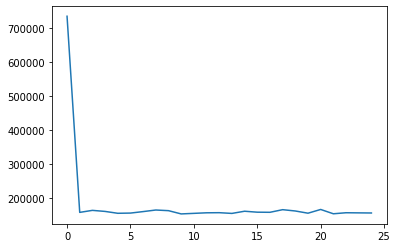

In [49]:
loss_per_epoch = model_sequential_and_FF.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

Se lleva a cabo el forecast de los ultimos 12 meses usando el modelo model_sequential_and_FF previamente definido y entrenado

Se toman los **ULTIMOS** n_input elementos de los **datos de train** y se almacenan en un batch

In [50]:

demanda_electrico_pretratamiento_median_train_batch = csv_demanda_electrico_pretratamiento_median_train_data.values[-n_input:]


demanda_electrico_pretratamiento_median_train_batch

array([3765.69 , 3772.25 , 3676.41 , 3500.08 , 3647.6  , 3807.71 ,
       3750.5  , 3876.48 , 2960.295, 2960.295, 2960.295, 2960.295,
       3037.44 , 3076.62 , 2947.09 , 3402.47 , 3402.47 , 3819.3  ,
       2960.295, 2960.295, 2960.295, 2960.295, 2960.295, 2960.295,
       3869.77 , 3996.14 , 3941.12 , 3298.43 , 3454.21 , 3681.3  ,
       4104.82 , 2960.295, 2960.295, 2960.295, 4098.81 , 2960.295])

Se reescala el batch de los datos de train a que tenga la misma forma que los datos con que se entrenó el modelo que fueron  1, input_shape=(n_input, n_features)

In [51]:
demanda_electrico_pretratamiento_median_train_batch_reshaped = demanda_electrico_pretratamiento_median_train_batch.reshape(1,n_input, n_features)
demanda_electrico_pretratamiento_median_train_batch_reshaped

array([[[3765.69 ],
        [3772.25 ],
        [3676.41 ],
        [3500.08 ],
        [3647.6  ],
        [3807.71 ],
        [3750.5  ],
        [3876.48 ],
        [2960.295],
        [2960.295],
        [2960.295],
        [2960.295],
        [3037.44 ],
        [3076.62 ],
        [2947.09 ],
        [3402.47 ],
        [3402.47 ],
        [3819.3  ],
        [2960.295],
        [2960.295],
        [2960.295],
        [2960.295],
        [2960.295],
        [2960.295],
        [3869.77 ],
        [3996.14 ],
        [3941.12 ],
        [3298.43 ],
        [3454.21 ],
        [3681.3  ],
        [4104.82 ],
        [2960.295],
        [2960.295],
        [2960.295],
        [4098.81 ],
        [2960.295]]])

Intentamos predecir el sigueinte valor dado el primet batch de n_input. Esto equivaldria a predecir el primer valor de los datos de test (PUES SE ESTÁN TOMANDO EXACTAMENTE LOS ULTIMOS VALORES DE LOS DATOS DE TRAIN EN EL BATCH), dados los n_input anteriores (QUE FORMAN BARTE DEL BATCH)

In [52]:
model_sequential_and_FF.predict(demanda_electrico_pretratamiento_median_train_batch_reshaped)

1/1 [==============================] - 0s 200ms/step


array([[[3962.7556],
        [3969.652 ],
        [3868.8987],
        [3683.5303],
        [3838.6123],
        [4006.9297],
        [3946.7869],
        [4079.2249],
        [3116.074 ],
        [3116.074 ],
        [3116.074 ],
        [3116.074 ],
        [3197.1736],
        [3238.3623],
        [3102.1924],
        [3580.9163],
        [3580.9163],
        [4019.114 ],
        [3116.074 ],
        [3116.074 ],
        [3116.074 ],
        [3116.074 ],
        [3116.074 ],
        [3116.074 ],
        [4072.1711],
        [4205.0186],
        [4147.178 ],
        [3471.5427],
        [3635.308 ],
        [3874.0398],
        [4319.27  ],
        [3116.074 ],
        [3116.074 ],
        [3116.074 ],
        [4312.952 ],
        [3116.074 ]]], dtype=float32)

Y se observa el valor predicho ESCALADO para la demanda de gas en el primer mes o dato de prueba como función de los n datos anteriores y dado el modelo model_sequential_and_FF

In [53]:
model_sequential_and_FF.predict(demanda_electrico_pretratamiento2_train_batch_reshaped)[0][-1][0]

1/1 [==============================] - 0s 32ms/step


3116.074

Ahora ser hará una función que irá formando batch de n_input para ir prediciendo el siguiente valor, tal como se hizo en el entrenamiento del modelo

In [54]:
n_input = 36
n_features = 1

In [55]:
test_predictions_model_sequential_and_FF = []

first_eval_batch = csv_demanda_electrico_pretratamiento_median_train_data.values[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(csv_demanda_electrico_pretratamiento_median_test_data)):
    
    # get the prediction value for the first batch
    current_pred = model_sequential_and_FF.predict(current_batch)[0][-1][0]
    
    # append the prediction into the array
    test_predictions_model_sequential_and_FF.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[[current_pred]]],axis=1)
    current_batch = current_batch.reshape((1, n_input, n_features))  # Reshape to maintain 

1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 21ms/step


In [56]:
test_predictions_model_sequential_and_FF

[3116.074,
 3279.8386,
 3451.998,
 3632.9832,
 3823.2463,
 4023.263,
 4233.532,
 4454.58,
 4686.96,
 4931.252,
 5188.0674,
 5458.048]

In [57]:
import numpy as np

# Convert the Python list to a NumPy array
test_predictions_model_sequential_and_FF_array = np.array(test_predictions_model_sequential_and_FF)

# Assuming test_predictions is your 1D array
# Reshape it into a 2D array with a single column
test_predictions_model_sequential_and_FF_2d = test_predictions_model_sequential_and_FF_array.reshape(-1, 1)

test_predictions_model_sequential_and_FF_2d

array([[3116.074 ],
       [3279.8386],
       [3451.998 ],
       [3632.9832],
       [3823.2463],
       [4023.263 ],
       [4233.532 ],
       [4454.58  ],
       [4686.96  ],
       [4931.252 ],
       [5188.0674],
       [5458.048 ]], dtype=float32)

In [58]:
test_predictions_model_sequential_and_FF_2d

array([[3116.074 ],
       [3279.8386],
       [3451.998 ],
       [3632.9832],
       [3823.2463],
       [4023.263 ],
       [4233.532 ],
       [4454.58  ],
       [4686.96  ],
       [4931.252 ],
       [5188.0674],
       [5458.048 ]], dtype=float32)

Separamos la Demanda de gas natural ORIGINAL en el sector eléctrico en data de train y test

In [59]:
# Number of data points to keep for testing (in this case, the last 12)
num_test_points = 12

# Split the data into training and testing sets
csv_demanda_electrico_original_train_data = csv_demanda_electrico_original[:-num_test_points]
csv_demanda_electrico_original_test_data = csv_demanda_electrico_original[-num_test_points:]

csv_demanda_electrico_original_train_data

,Demanded_Gas
Date,
2005-01-01,1819.580
2005-02-01,1895.330
2005-03-01,2960.295
2005-04-01,2960.295
2005-05-01,1895.540
...,...
2021-05-01,2960.295
2021-06-01,2960.295
2021-07-01,2960.295


In [29]:
csv_demanda_electrico_original_test_data['Demanded_Gas'].values

array([2960.295, 2960.295, 2960.295, 3320.75 , 3449.8  , 3206.96 ,
       3403.44 , 3350.03 , 3498.7  , 3350.97 , 3506.42 , 3778.37 ])

Text(0, 0.5, 'Demanda [MMpcd]')

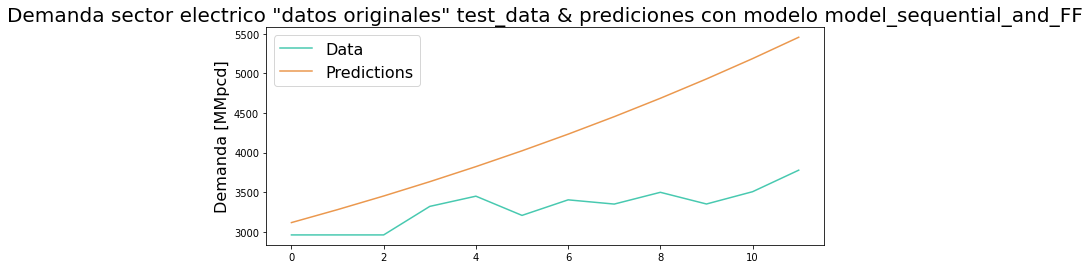

In [60]:
##Ploting the predicitons vs the test_data
plt.figure(figsize =(10,4))
plt.plot(csv_demanda_electrico_original_test_data['Demanded_Gas'].values, color='#48C9B0')
plt.plot(test_predictions_model_sequential_and_FF , color='#EB984E')
plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Demanda sector electrico "datos originales" test_data & prediciones con modelo model_sequential_and_FF', fontsize=20)
plt.ylabel('Demanda [MMpcd]', fontsize=16)

In [61]:
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import numpy as np

# Compute errors
MAPE_predictions_model_sequential_and_FF_pretratamiento_median = mean_absolute_percentage_error(csv_demanda_electrico_original_test_data['Demanded_Gas'].values, test_predictions_model_sequential_and_FF )
RMSE_predictions_model_sequential_and_FF_pretratamiento_median = np.sqrt(mean_squared_error(csv_demanda_electrico_original_test_data['Demanded_Gas'].values, test_predictions_model_sequential_and_FF ))

print('MAPE:', MAPE_predictions_model_sequential_and_FF_pretratamiento_median)
print('RMSE:', RMSE_predictions_model_sequential_and_FF_pretratamiento_median)

MAPE: 0.2577045504454312
RMSE: 1030.3333470341558
